<a href="https://colab.research.google.com/github/satishgaurav/DeepChem_MolGAN/blob/master/my_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Print all variable
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
## Install deepchem 
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install --pre deepchem

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  13211      0 --:--:-- --:--:-- --:--:-- 13211


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added omnia to channels
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda

     |████████████████████████████████| 552kB 8.6MB/s 


In [4]:
import tensorflow as tf

In [5]:
import deepchem as dc
import rdkit as rdkit
import rdkit.Chem as Chem
import rdkit.Chem.PandasTools as pt
import pandas as pd

In [6]:
import numpy as np

In [7]:
print('tf version:', tf.__version__, '\nGPU avilable?:', tf.config.list_physical_devices('GPU'))
print('rdkit version: ', rdkit.__version__)
print('DeepChem version', dc.__version__)

tf version: 2.4.1 
GPU avilable?: []
rdkit version:  2020.09.1
DeepChem version 2.6.0.dev


In [8]:
import sys
sys.path.insert(1, '/content/drive/MyDrive/DeepChem_MolGAN/')

In [9]:
from layers.layers import GraphEncoderLayer
from tensorflow.keras import layers

In [10]:
data = pd.read_csv('/content/drive/MyDrive/DeepChem_MolGAN/data/QM9_HAC_5_9_.csv')

In [11]:
reduced_data = list(data['SMILES'])
import random
random.shuffle(reduced_data)

In [12]:
mols = list(filter(lambda x: x is not None, [Chem.MolFromSmiles(x) for x in reduced_data]))
print('how many molecules obtained from smiles: ', len(mols))

how many molecules obtained from smiles:  132432


In [39]:
import logging
from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol, List
from deepchem.feat.base_classes import MolecularFeaturizer

logger = logging.getLogger(__name__)

class GraphMatrix():
    """
    This is class used to store data for MolGAN neural networks.
    
    Parameters
    ----------
    node_features: np.ndarray
      Node feature matrix with shape [num_nodes, num_node_features]
    edge_features: np.ndarray,
      Edge feature matrix with shape [num_nodes, num_nodes]
      
    Returns
    -------
    graph: GraphMatrix
      A molecule graph with some features.
    """   
    
    def __init__(self,adjacency_matrix: np.ndarray, node_features: np.ndarray):
        self.adjacency_matrix = adjacency_matrix
        self.node_features = node_features


class MolGanFeaturizer(MolecularFeaturizer):
    """This class implements featurizer used with MolGAN de-novo molecular generation based on:
    `MolGAN: An implicit generative model for small molecular graphs`<https://arxiv.org/abs/1805.11973>`_.
    The default representation is in form of GraphMatrix object, being wrapper for two matrices containing atom and bond type information.
    The class also provides reverse capabilities"""
    
    def __init__(self,
                max_atom_count:int = 9,
                kekulize:bool = True,
                bond_labels: List[RDKitBond] = None,
                atom_labels: List[int] = None):
        """
        Parameters
        ----------
        max_atom_count: int, default 9
            Maximum number of atoms used for creation of adjacency matrix, molecules cannot have more atoms than this number; implicit hydrogens do not count.
        kekulize: bool, default True
            Should molecules be kekulized; solves number of issues with defeaturization when used.
        bond_labels: List[RDKitBond]
            List containing types of bond used for generation of adjacency matrix
        atom_labels: List[int]
            List of atomic numbers used for generation of node features
        """
        self.max_atom_count = max_atom_count
        self.kekulize = kekulize

        #bond labels
        if bond_labels is None:
            self.bond_labels = [
                Chem.rdchem.BondType.ZERO
                ,Chem.rdchem.BondType.SINGLE
                ,Chem.rdchem.BondType.DOUBLE
                ,Chem.rdchem.BondType.TRIPLE
                ,Chem.rdchem.BondType.AROMATIC]
        else:
            self.bond_labels = bond_labels

        #atom labels
        if atom_labels is None:
            self.atom_labels = [0, 6, 7, 8, 9] #C,N,O,F
        else:
            self.atom_labels = atom_labels

        #create bond encoders and decoders
        self.bond_encoder = {l: i for i, l in enumerate(self.bond_labels)}
        self.bond_decoder = {i: l for i, l in enumerate(self.bond_labels)}
        #create atom encoders and decoders
        self.atom_encoder = {l: i for i, l in enumerate(self.atom_labels)}
        self.atom_decoder = {i: l for i, l in enumerate(self.atom_labels)}
    
    def _featurize(self, mol: RDKitMol) -> GraphMatrix:
        """Calculate adjacency matrix and nodes features for RDKitMol.
        
        Parameters
        ----------
        mol: rdkit.Chem.rdchem.Mol
          RDKit mol object.
        Returns
        -------
        graph: GraphMatrix
          A molecule graph with some features.
        """
        if self.kekulize:
            Chem.Kekulize(mol)
            
        A = np.zeros(shape=(self.max_atom_count, self.max_atom_count), dtype=np.float32)
        bonds = mol.GetBonds()

        begin, end = [b.GetBeginAtomIdx() for b in bonds], [b.GetEndAtomIdx() for b in bonds]
        bond_type = [self.bond_encoder[b.GetBondType()] for b in bonds]

        A[begin, end] = bond_type
        A[end, begin] = bond_type

        degree = np.sum(A[:mol.GetNumAtoms(), :mol.GetNumAtoms()], axis=-1)
        X = np.array([self.atom_encoder[atom.GetAtomicNum()] for atom in mol.GetAtoms()] + [0] * (self.max_atom_count - mol.GetNumAtoms()), dtype=np.int32)       
        graph = GraphMatrix(A,X)
           
        return graph if (degree > 0).all() else None
    
    def _defeaturize(self, graph_matrix: GraphMatrix, sanitize:bool = True, cleanup=True) ->RDKitMol:
        """Recreate RDKitMol from GraphMatrix object. For working correctly same object needs to be used for featurization and defeaturization.
        
        Parameters
        ----------
        graph_matrix: GraphMatrix
            GraphMatrix object.
        sanitize: bool, default True
            Should RDKit sanitization be included in the process.
        cleanup: bool, default True
            Splits salts and removes compounds with "*" atom types
            
        Returns
        -------
        mol: RDKitMol object
            RDKitMol object representing molecule.
        """
        
        node_labels = graph_matrix.node_features
        edge_labels = graph_matrix.adjacency_matrix

        mol = Chem.RWMol()

        for node_label in node_labels:
            mol.AddAtom(Chem.Atom(self.atom_decoder[node_label]))

        for start, end in zip(*np.nonzero(edge_labels)):
            if start > end:
                mol.AddBond(int(start), int(end), self.bond_decoder[edge_labels[start, end]])

        if sanitize:
            try:
                Chem.SanitizeMol(mol)
            except Exception:
                mol = None
                
        if cleanup:
            try:
                smiles = Chem.MolToSmiles(mol)
                smiles = max(smiles.split('.'), key=len)
                if "*" not in smiles:
                    mol = Chem.MolFromSmiles(smiles)
                else:
                    mol = None
            except Exception:
                mol = None
            

        return mol
    
    def defeaturize(self, graphs, log_every_n=1000) -> np.ndarray:
        """Calculates molecules from correspoing GraphMatrix objects.
        Parameters
        ----------
        graphs: GraphMatrix / iterable
          GraphMatrix object or corresponding iterable
        log_every_n: int, default 1000
          Logging messages reported every `log_every_n` samples.
        Returns
        -------
        features: np.ndarray
          A numpy array containing RDKitMol objext.
        """
        # Special case handling of single molecule
        if isinstance(graphs, GraphMatrix):
            graphs = [graphs]
        else:
            # Convert iterables to list
            graphs = list(graphs)

        molecules = []
        for i, gr in enumerate(graphs):
            if i % log_every_n == 0:
                logger.info("Featurizing datapoint %i" % i)

            try:
                molecules.append(self._defeaturize(gr))
            except Exception as e:
                logger.warning("Failed to defeaturize datapoint %d, %s. Appending empty array", i,gr)
                logger.warning("Exception message: {}".format(e))
                molecules.append(np.array([]))

        molecules = np.asarray(molecules)
        return molecules

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from deepchem.models import WGAN

from layers.layers import GraphEncoderLayer

class MolGAN(WGAN):
    """Model for automatic generation of compounds based on GAN architecture described by Nicola De Cao et al.
    `MolGAN: An implicit generative model for small molecular graphs`<https://arxiv.org/abs/1805.11973>`_.
    It uses adjacency matrix and node features as inputs, both need to be converted to one hot representation before use.
    
    
    Examples
    --------
    gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))
    dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in limited],[x.node_features for x in limited])
    def iterbatches(epochs):
        for i in range(epochs):
            for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
                adjacency_tensor = tf.one_hot(batch[0], gan.edges)
                node_tesor = tf.one_hot(batch[1], gan.nodes)
                yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tesor}
    gan.fit_gan(iterbatches(10), generator_steps=0.2, checkpoint_interval=5000)
    
    """
    
    def __init__(self
                 ,edges: int = 5
                 ,vertices:int = 9
                 ,nodes: int = 5
                 ,embedding_dim: int = 10
                 ,dropout_rate: float = 0.
                 ,name:str =''
                 , **kwargs):
        """
        Parameters
        ----------
        edges: int, default 5
            Number of bond types includes BondType.Zero
        vertices: int, default 9
            Max number of atoms in adjacency and node features matrices
        nodes: int, default 5
            Number of atom types in node features matrix
        embedding_dim: int, default 10
            Size of noise input
        dropout_rate: float, default = 0.
            Rate of dropout used across whole model
        name: str, default ''
            Name of the model
        """

        self.edges = edges
        self.vertices = vertices
        self.nodes =nodes
        self.embedding_dim = embedding_dim
        self.dropout_rate = dropout_rate
        
        super(MolGAN, self).__init__(name=name, **kwargs)

    def get_noise_input_shape(self):
        return (self.embedding_dim,)

    def get_data_input_shapes(self):
        return [(self.vertices, self.vertices, self.edges), (self.vertices, self.nodes)]

    def create_generator(self):
        
        print("creating generator...")

        input_layer = layers.Input(shape=(self.embedding_dim,))
        x = layers.Dense(128, activation='tanh')(input_layer)
        x = layers.Dropout(self.dropout_rate)(x)
        x = layers.Dense(256, activation='tanh')(x)
        x = layers.Dropout(self.dropout_rate)(x)
        x = layers.Dense(512, activation='tanh')(x)
        x = layers.Dropout(self.dropout_rate)(x)

        #EDGES LOGITS
        edges_logits = layers.Dense(units=self.edges*self.vertices*self.vertices, activation=None)(x)
        edges_logits = layers.Reshape((self.edges, self.vertices, self.vertices))(edges_logits)
        matrix_transpose = layers.Permute((1,3,2))(edges_logits)
        edges_logits = (edges_logits + matrix_transpose)/2
        edges_logits = layers.Permute((2,3,1))(edges_logits)
        edges_logits = layers.Dropout(self.dropout_rate)(edges_logits)
        
        #used during training of the model
        edges_softmax = tf.nn.softmax(edges_logits)

        #NODES LOGITS
        nodes_logits = layers.Dense(units=(self.vertices * self.nodes), activation=None)(x)
        nodes_logits = layers.Reshape((self.vertices, self.nodes))(nodes_logits)
        nodes_logits = layers.Dropout(self.dropout_rate)(nodes_logits)
        
        #used during training of the model
        nodes_softmax = tf.nn.softmax(nodes_logits)
        
        #used to generate molecules, consider returning just logits and then use additonal layer when molecules needs to generated
        
        #used for compound generation, consider removing this from this section and just return un
        e_gumbel_logits = edges_logits - tf.math.log(- tf.math.log(tf.random.uniform(tf.shape(edges_logits), dtype=edges_logits.dtype)))
        e_gumbel_argmax = tf.one_hot(tf.argmax(e_gumbel_logits, axis=-1), depth=e_gumbel_logits.shape[-1], dtype=e_gumbel_logits.dtype) 
        e_argmax = tf.argmax(e_gumbel_argmax, axis=-1)
        
        
        #used for compound generation
        n_gumbel_logits = nodes_logits - tf.math.log(- tf.math.log(tf.random.uniform(tf.shape(nodes_logits), dtype=nodes_logits.dtype)))
        n_gumbel_argmax = tf.one_hot(tf.argmax(n_gumbel_logits, axis=-1), depth=n_gumbel_logits.shape[-1], dtype=n_gumbel_logits.dtype)
        n_argmax = tf.argmax(n_gumbel_argmax, axis=-1)
        
        #final model
        return keras.Model(inputs = input_layer, outputs=[edges_softmax, nodes_softmax,e_argmax, n_argmax])
    
    def create_discriminator(self):
        adjacency_tensor= layers.Input(shape=(self.vertices, self.vertices, self.edges))
        node_tensor = layers.Input(shape=(self.vertices, self.nodes))

        print("creating discriminator...")

        graph = GraphEncoderLayer(units = [(128,64),128], dropout_rate= self.dropout_rate, edges=self.edges)([adjacency_tensor,node_tensor])
        dense = layers.Dense(units=128, activation='tanh')(graph)
        dense = layers.Dropout(self.dropout_rate)(dense)
        dense = layers.Dense(units=64, activation='tanh')(dense)
        dense = layers.Dropout(self.dropout_rate)(dense)
        output = layers.Dense(units=1)(dense)
               
        return keras.Model(inputs=[(adjacency_tensor, node_tensor)], outputs=[output])
    
    def predict_gan_generator(self,
                            batch_size=1,
                            noise_input=None,
                            generator_index=0):
        """Use the GAN to generate a batch of samples.
        Parameters
        ----------
        batch_size: int
          the number of samples to generate.  If either noise_input or
          conditional_inputs is specified, this argument is ignored since the batch
          size is then determined by the size of that argument.
        noise_input: array
          the value to use for the generator's noise input.  If None (the default),
          get_noise_batch() is called to generate a random input, so each call will
          produce a new set of samples.
        generator_index: int
          the index of the generator (between 0 and n_generators-1) to use for
          generating the samples.
        Returns
        -------
        An array (if the generator has only one output) or list of arrays (if it has
        multiple outputs) containing the generated samples.
        """
        if noise_input is not None:
            batch_size = len(noise_input)
        if noise_input is None:
            noise_input = self.get_noise_batch(batch_size)
        inputs = noise_input
        _,_,adjacency_matrix, nodes_features = gan.generators[0](inputs, training=False)
        graphs = [GraphMatrix(i,j) for i,j in zip(adjacency_matrix.numpy(),nodes_features.numpy())] 
        return graphs

In [15]:
#create featurizer
feat = MolGanFeaturizer()
#featurize molecules
limited = feat.featurize(mols)
#Remove empty objects
limited = list(filter(lambda x: x is not None, limited))

In [16]:
#create dataset
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in limited],[x.node_features for x in limited])

In [96]:
from deepchem.models.optimizers import ExponentialDecay
#create model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

creating generator...
creating discriminator...


In [60]:
#prepare data for training
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
      # print("batch shape:", len(batch))
      # print("type of tuple elements:\n", "1:", type(batch[0]), "2:", type(batch[1]), "3:", type(batch[2]), "4:", type(batch[3]))
      # print("size of tuple elemetns:\n", "1:", batch[0].shape, "2:", batch[1].shape, "3:", batch[2].shape, "4:", batch[3].shape)
      adjacency_tensor = tf.one_hot(batch[0], gan.edges)
      node_tensor = tf.one_hot(batch[1], gan.nodes)
      # print("shape of adjancency tensor: ", adjacency_tensor.shape)
      # print("shape of node tensor: ", node_tensor.shape)
      yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]: node_tensor}

a = list(iterbatches(1))

In [68]:
print("length of a: ", len(a))
print("object type in a:", type(a[0]))
print("no of object in dictionary: ", len(a[1]))
# print("first object from dictionary: ", a[1)
print(a[1].keys())

length of a:  1324
object type in a: <class 'dict'>
no of object in dictionary:  2
dict_keys([<Reference wrapping <KerasTensor: shape=(None, 9, 9, 5) dtype=float32 (created by layer 'input_13')>>, <Reference wrapping <KerasTensor: shape=(None, 9, 5) dtype=float32 (created by layer 'input_14')>>])


In [71]:
for key, value in a[1].items():
  print("key name: ", key)
  print("shape of value: ", value.shape)

key name:  <Reference wrapping <KerasTensor: shape=(None, 9, 9, 5) dtype=float32 (created by layer 'input_13')>>
shape of value:  (100, 9, 9, 5)
key name:  <Reference wrapping <KerasTensor: shape=(None, 9, 5) dtype=float32 (created by layer 'input_14')>>
shape of value:  (100, 9, 5)


In [39]:
# #prepare data for training
# def iterbatches(epochs):
#     for i in range(epochs):
#         for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
#             adjacency_tensor = tf.one_hot(batch[0], gan.edges)
#             node_tensor = tf.one_hot(batch[1], gan.nodes)
#             yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]: node_tensor}
#             # yield {adjacency_tensor, node_tensor}

In [97]:
#train model
gan.fit_gan(iterbatches(1), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 1323: generator average loss -27.1555, discriminator average loss -11.0837
TIMING: model fitting took 101.187 s


In [98]:
#generat prediced sample
g = gan.predict_gan_generator(1000)

In [99]:
#convert graphs to RDKitmolecules
nmols = feat.defeaturize(g)
print("{} molecules generated".format(len(nmols)))

1000 molecules generated


In [100]:
#remove invalid moles
nmols = list(filter(lambda x: x is not None, nmols))
print ("{} valid molecules".format(len(nmols)))

894 valid molecules


In [101]:
#get unique molecules
nmols = [Chem.MolFromSmiles(x) for x in list(set([Chem.MolToSmiles(z) for z in nmols]))]
print("{} unique molecules".format(len(nmols)))

7 unique molecules


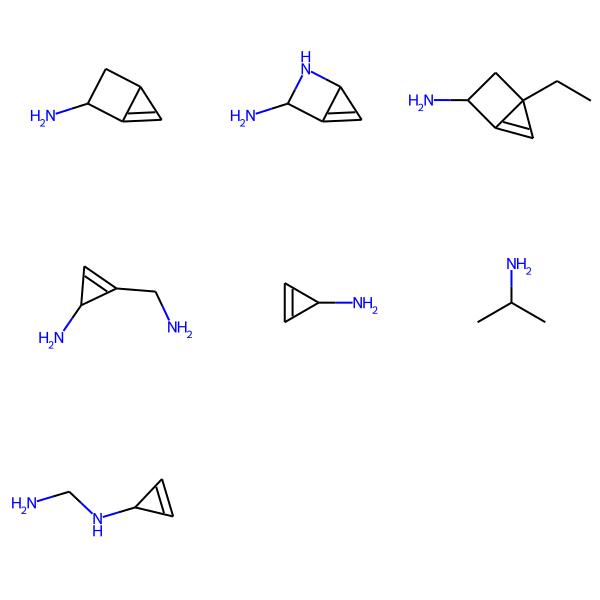

In [102]:
#display unique molecules
Chem.Draw.MolsToGridImage(nmols)